In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import os
import time
import math
from numpy import exp, sum
from scipy.optimize import differential_evolution

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
if not os.path.exists('./plots/p'): os.makedirs('./plots/p')

In [3]:
end = 20
DELTA = 0.02
n = int(end/DELTA)

beta1 = 8.0
beta2 = 4.0
beta3 = 5.0

lambda1 = 0.5
lambda2 = 3.0
lambda3 = 2.0
beta = beta1 + beta2 + beta3

p11 = 1.0
p12 = 0.06
p13 = 0.05

p21 = 0.03
p22 = 1.0
p23 = 0.01

p31 = 0.007
p32 = 0.005
p33 = 1.0


eta1 = 0.35
eta = 0.3
c=0.3
d = np.array((n+1)*[0.0])
dhat = np.array(n*[0.0])
dhat0 = np.array(n*[0.0])

d[0] = 1.0
B1 = np.array(n*[0.0])
B2 = np.array(n*[0.0])
B3 = np.array(n*[0.0]) 
B10 = np.array(n*[0.0])
B20 = np.array(n*[0.0])
B30 = np.array(n*[0.0]) 
d = np.array((n+1)*[0.0])
dhat = np.array(n*[0.0])
dhat0 = np.array(n*[0.0])
d1 = np.array((n+1)*[0.0])
dhat1 = np.array(n*[0.0])
d[0] = 1.0
d1[0] = 1.0
B1 = np.array(n*[0.0])
B2 = np.array(n*[0.0])
B3 = np.array(n*[0.0]) 

In [4]:
NAME = '-p-'+str(lambda1)+'-'+str(lambda2)+'-'+str(lambda3)+'-'+str(beta1)+ '-' + str(beta2) +'-'+ str(beta3)+'-'+str(p11)+'-' +str(p12)+'-'+str(p13)+'-'+str(p21)+'-'+str(p22)+'-'+str(p23)+ '-'+str(p31)+ '-'+str(p32)+ '-'+str(p33)+ '-'+str(eta1)+ '-'+str(eta) + '.pdf'

In [5]:
def F1(b1, x): return 1-exp(-lambda1*x/b1)

def F2(b2, x): return 1-exp(-lambda2*x/b2)

def F3(b3, x): return 1-exp(-lambda3*x/b3)

def F12(b1, b2, u):
    return (-b1*lambda2*exp(-u*lambda1/b1)+b2*lambda1*exp(-lambda2*u/b2)+b1*lambda2-b2*lambda1)/(b1*lambda2-b2*lambda1)

def F13(b1, b3, u):
    return (-b1*lambda3*exp(-u*lambda1/b1)+b3*lambda1*exp(-lambda3*u/b3)+b1*lambda3-b3*lambda1)/(b1*lambda3-b3*lambda1)

def F23(b2, b3, u):
    return (-b2*lambda3*exp(-lambda2*u/b2)+b3*lambda2*exp(-lambda3*u/b3)+b2*lambda3-b3*lambda2)/(b2*lambda3-b3*lambda2)

def F123(b1, b2, b3, u):
    return (b2**2*lambda1*lambda3*(b1*lambda3-b3*lambda1)*exp(-lambda2*u/b2)-b3**2*lambda1*lambda2*(b1*lambda2-b2*lambda1)*exp(-lambda3*u/b3)-(exp(-u*lambda1/b1)*b1**2*lambda2*lambda3-(b1*lambda3-b3*lambda1)*(b1*lambda2-b2*lambda1))*(b2*lambda3-b3*lambda2))/((b2*lambda3-b3*lambda2)*(b1*lambda3-b3*lambda1)*(b1*lambda2-b2*lambda1))

def GR(b1, b2, b3, x):
    return (x>0)*(beta1*(1-p12)*(1-p13)*F1(b1, x) + beta2*(1-p21)*(1-p23)*F2(b2, x) + beta3*(1-p31)*(1-p32)*F3(b3, x) + (beta1*p12*(1-p13) + beta2*p21*(1-p23))*F12(b1, b2, x) + (beta1*p13*(1-p12) + beta2*p31*(1-p32))*F13(b1, b3, x) + (beta2*p23*(1-p21)+beta3*p23*(1-p31))*F23(b2, b3, x) + (beta1*p11*p12*p13 + beta2*p21*p22*p23 + beta3*p31*p32*p33)*F123(b1, b2, b3, x))/beta


In [6]:
F1=numba.jit(F1,nopython = True)
F2=numba.jit(F2,nopython = True)
F3=numba.jit(F3,nopython = True)

F12=numba.jit(F12,nopython = True)
F13=numba.jit(F13,nopython = True)
F23=numba.jit(F23,nopython = True)

F123=numba.jit(F123,nopython = True)
GR=numba.jit(GR,nopython = True)

In [7]:
@numba.jit(nopython = True) 
def DGR(b1, b2, b3, j):
    return GR(b1,b2,b3,j*DELTA)-GR(b1,b2,b3,(j-1)*DELTA)

In [8]:
def IR(i,b1,b2,b3):
    j = np.arange(i+1)
    return np.sum(d[i-j]*DGR(b1, b2, b3, j))

In [9]:
@numba.jit(nopython = True) 
def E(b1,b2,b3): 
    return ((b3*((p23*(1+(p22-1)*p21)-(p32-1)*p31)*beta2+((1-p31)*p23+(-1+(p33+1)*p32)*p31-p32+1)*beta3+(1+(p11-1)*p12)*p13*beta1)*lambda2+b2*((1+p21*(p22-1)*p23)*beta2+((1-p31)*p23+p31*p32*p33)*beta3+(1+p13*(p11-1))*p12*beta1)*lambda3)*lambda1+lambda2*((p21*(p22-1)*p23+(1-p32)*p31+p21)*beta2+beta3*p31*p32*p33+(1+p13*(p11-1)*p12)*beta1)*lambda3*b1)/(lambda2*lambda3*lambda1*beta)

E1 = E(1,1,1)
@numba.jit(nopython = True) 
def pR(b1,b2,b3):
    return (1+eta)*beta*E1 - ((1+eta1)*beta*(E1-E(b1,b2,b3)))

In [12]:
for i in range(n):
    def H(b):
        pRR = pR(b[0],b[1],b[2])
        j1 = np.arange(i)
        j2 = np.arange(1,i+1)
        if pRR>0: return ((c+beta)*d[i]-0.5*beta*sum((d[i-j1]+d[i-j2])*DGR(b[0], b[1], b[2], j2)))/pRR
        else : return  np.inf
    MIN = differential_evolution(H, [(0.01, 1.0), (0.01, 1.0),(0.01, 1.0)])#,popsize=30, strategy='rand1exp')
    dhat[i] = MIN.fun
    d[i+1]=d[i]+DELTA*dhat[i]

    B1[i] = MIN.x[0]
    B2[i] = MIN.x[1]
    B3[i] = MIN.x[2]
    if i%(n//20)==0: 
        print(str(round(100*i/n))+'%', end=', ')
        print('d('+str(round(i*DELTA,2))+') = '+str(d[i]))
print('100%')

0%, d(0.0) = 1.0
5%, d(1.0) = 1.3898629462814867
10%, d(2.0) = 1.7365785141277092
15%, d(3.0) = 2.0510691341842526
20%, d(4.0) = 2.341005615979088
25%, d(5.0) = 2.6115844379252193
30%, d(6.0) = 2.866612595370824
35%, d(7.0) = 3.109273926941671
40%, d(8.0) = 3.3423103034600112
45%, d(9.0) = 3.568101175941171
50%, d(10.0) = 3.7887196949396684
55%, d(11.0) = 4.005978854879323
60%, d(12.0) = 4.221470715733588
65%, d(13.0) = 4.436599962984798
70%, d(14.0) = 4.6526126682687154
75%, d(15.0) = 4.8706209538027965
80%, d(16.0) = 5.091624156545627
85%, d(17.0) = 5.316527001054076
90%, d(18.0) = 5.546155216355802
95%, d(19.0) = 5.781268969281028
100%


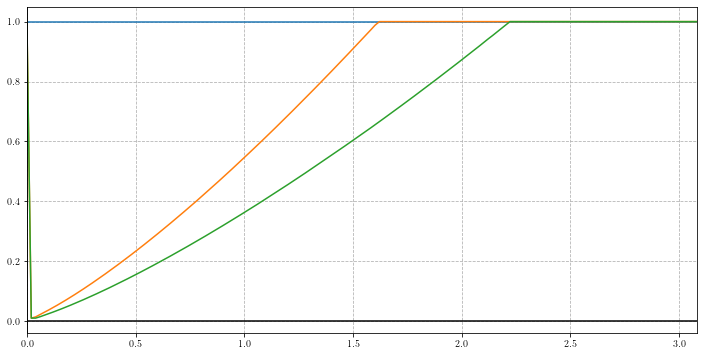

In [13]:
x = np.linspace(0,end,n)
plt.figure(figsize=(12,6))
plt.plot(x, B1)
plt.plot(x, B2)
plt.plot(x, B3)
#plt.ylim(.99,1.10)
plt.xlim(0,3.08)
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')
plt.show()

In [14]:
delta = d
deltahat = dhat

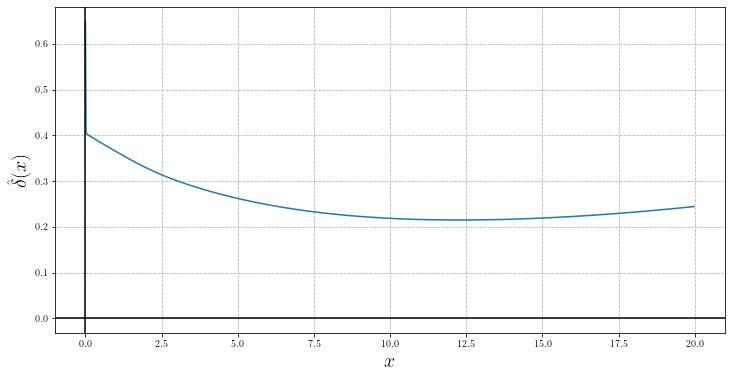

In [15]:
x = np.linspace(0,i*DELTA,i)
plt.figure(figsize=(12,6))
plt.plot(x,deltahat[0:i])
plt.xlabel('$x$', fontsize=20)
plt.ylabel(r'$\hat{\delta}(x)$', fontsize=20)
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')
#plt.savefig("./plots/ExcessOfLoss/DELTAhat" +NAME, bbox_inches='tight')
plt.show()

In [16]:
IndMin = np.argmin(deltahat)

In [17]:
deltahat[IndMin]

0.21504377134514227

In [18]:
IndMin*DELTA

12.26

In [19]:
x = np.linspace(0,end,n+1)
v = delta
vhat = deltahat
V = v/vhat[IndMin]
Vp = vhat/vhat[IndMin]

V[IndMin+1:] = V[IndMin] + np.arange(IndMin+1, n+1)*DELTA - (IndMin)*DELTA
Vp[IndMin+1:] = 1.0

In [20]:
Vppp=V-x

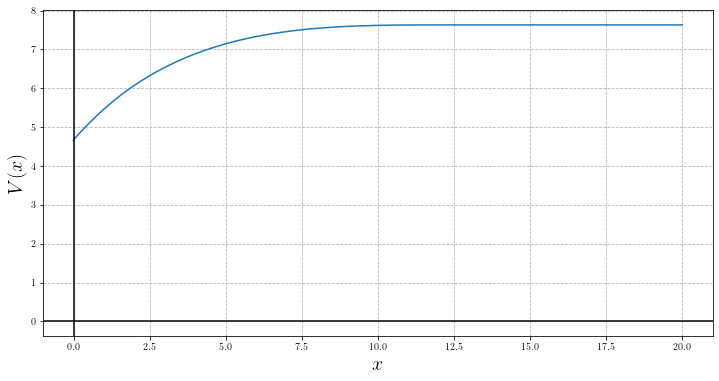

In [21]:
x = np.linspace(0,end,n+1)
plt.figure(figsize=(12,6))
plt.plot(x, Vppp)
plt.xlabel('$x$', fontsize=20)
plt.ylabel(r'$V(x)$', fontsize=20)
#plt.xlim(0,17.5)
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')
plt.show()

In [22]:
import pandas as pd
IND = np.arange(0,n)
x = np.linspace(0,end,n+1)
DF = pd.DataFrame([x[IND],Vppp[IND],B1[IND],B2[IND],B3[IND]],
                  index=['x','V_ppp','ppp_Line1','ppp_Line2','ppp_Line3']).T
DF.to_csv('ppp_20_0.02.csv')